In [65]:
import pandas as pd 


In [66]:
import tensorflow


import json
import requests
from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout, LSTM
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics import mean_absolute_error
%matplotlib inline

In [67]:
data = pd.read_csv("data\doge_data.csv")
data = data.rename({'Datetime': 'Date'}, axis=1)
data

,Date,Open,High,Low,Close,Adj Close,Volume
0,2020-12-31 23:00:00+00:00,0.004672,0.004704,0.004648,0.004683,0.004683,0
1,2021-01-01 00:00:00+00:00,0.004681,0.004703,0.004615,0.004693,0.004693,0
2,2021-01-01 01:00:00+00:00,0.004693,0.004752,0.004689,0.004739,0.004739,0
3,2021-01-01 02:00:00+00:00,0.004738,0.004752,0.004729,0.004750,0.004750,0
4,2021-01-01 03:00:00+00:00,0.004750,0.004983,0.004750,0.004978,0.004978,9477800
...,...,...,...,...,...,...,...
2174,2021-04-01 18:00:00+00:00,0.058733,0.059011,0.057618,0.058724,0.058724,173274112
2175,2021-04-01 19:00:00+00:00,0.058836,0.059053,0.058329,0.058545,0.058545,75353600
2176,2021-04-01 20:00:00+00:00,0.058543,0.060973,0.058543,0.059997,0.059997,252666880
2177,2021-04-01 21:00:00+00:00,0.059989,0.059989,0.059005,0.059294,0.059294,56687104


In [68]:
data = data.set_index("Date")


In [69]:
def train_test_split(df, test_size=0.2):
    split_row = len(df) - int(test_size * len(df))
    train_data = df.iloc[:split_row]
    test_data = df.iloc[split_row:]
    return train_data, test_data

train, test = train_test_split(data, test_size=0.2)


In [70]:
def line_plot(line1, line2, label1=None, label2=None, title='', lw=2):
    fig, ax = plt.subplots(1, figsize=(13, 7))
    ax.plot(line1, label=label1, linewidth=lw)
    ax.plot(line2, label=label2, linewidth=lw)
    ax.set_ylabel('price [BTC]', fontsize=14)
    ax.set_title(title, fontsize=16)
    ax.legend(loc='best', fontsize=16);

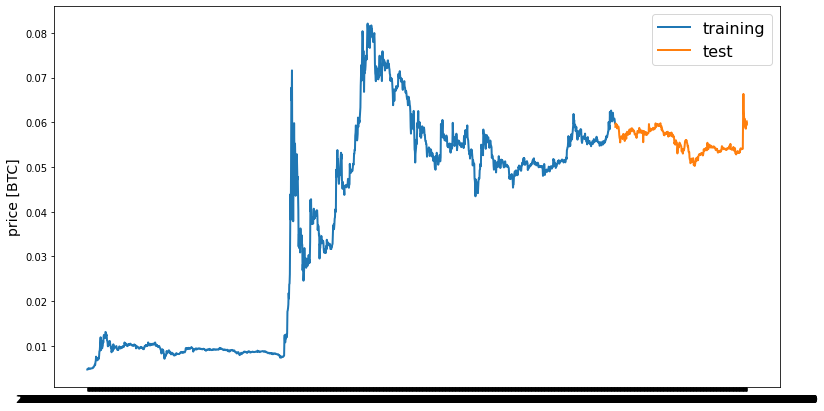

In [71]:
line_plot(train['Close'], test['Close'], 'training', 'test', title='')

In [72]:
def normalise_zero_base(df):
    return df / df.iloc[0] - 1

def normalise_min_max(df):
    return (df - df.min()) / (data.max() - df.min())


In [73]:
def extract_window_data(df, window_len=5, zero_base=True):
    window_data = []
    for idx in range(len(df) - window_len):
        tmp = df[idx: (idx + window_len)].copy()
        if zero_base:
            tmp = normalise_zero_base(tmp)
        window_data.append(tmp.values)
    return np.array(window_data)


In [74]:
def prepare_data(df, target_col, window_len=10, zero_base=True, test_size=0.2):
    train_data, test_data = train_test_split(df, test_size=test_size)
    X_train = extract_window_data(train_data, window_len, zero_base)
    X_test = extract_window_data(test_data, window_len, zero_base)
    y_train = train_data[target_col][window_len:].values
    y_test = test_data[target_col][window_len:].values
    if zero_base:
        y_train = y_train / train_data[target_col][:-window_len].values - 1
        y_test = y_test / test_data[target_col][:-window_len].values - 1

    return train_data, test_data, X_train, X_test, y_train, y_test


In [75]:
def build_lstm_model(input_data, output_size, neurons=100, activ_func='linear',
                     dropout=0.2, loss='mse', optimizer='adam'):
    model = Sequential()
    model.add(LSTM(neurons, input_shape=(input_data.shape[1], input_data.shape[2])))
    model.add(Dropout(dropout))
    model.add(Dense(units=output_size))
    model.add(Activation(activ_func))

    model.compile(loss=loss, optimizer=optimizer)
    return model

In [76]:
np.random.seed(42)
window_len = 5
test_size = 0.2
zero_base = True
lstm_neurons = 100
epochs = 20
batch_size = 32
loss = 'mse'
dropout = 0.2
optimizer = 'adam'


In [77]:
train, test, X_train, X_test, y_train, y_test = prepare_data(
    data, 'Close', window_len=window_len, zero_base=zero_base, test_size=test_size)


In [78]:
model = build_lstm_model(
    X_train, output_size=1, neurons=lstm_neurons, dropout=dropout, loss=loss,
    optimizer=optimizer)
history = model.fit(
    X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=1, shuffle=True)


NotImplementedError: Cannot convert a symbolic Tensor (lstm/strided_slice:0) to a numpy array. This error may indicate that you're trying to pass a Tensor to a NumPy call, which is not supported

In [ ]:
targets = test['Close'][window_len:]
preds = model.predict(X_test).squeeze()
mean_absolute_error(preds, y_test)

0.02620592906584379

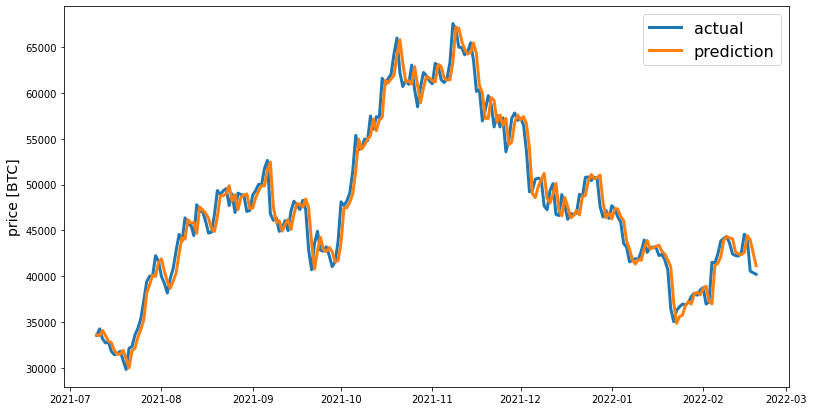

In [ ]:
preds = test['Close'].values[:-window_len] * (preds + 1)
preds = pd.Series(index=targets.index, data=preds)
line_plot(targets, preds, 'actual', 'prediction', lw=3)